Importing Libraries 

In [1]:
# Loading MNSIT Dataset
import keras
from keras.datasets import mnist
from keras.layers import Flatten

# Spliting Dataset
from sklearn.model_selection import train_test_split

# To build Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
import torch.utils.data as data_utils

# Build Neural Network Summary
from torchinfo import summary
# Calculate Accuarcy of Model
from torchmetrics import Accuracy

# For plotting graph
import matplotlib.pyplot as plt

import numpy as np

2024-02-08 19:12:17.107203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 19:12:17.107308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 19:12:17.108836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 19:12:17.115706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 19:12:18.100582: W tensorflow/compiler/tf2

Switch to device if cuda is available

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used : ", device)

Device used :  cuda


# Loading MNIST Dataset

- MNIST Dataset Load
- Splitting the dataset into Train, Test, Validation
- Data preprocessing 
  - Normalizing
  - Converting output labels to one - hot vectors 
  - Reshaping (X : Train , Test , Validation) format as per pytorch
    - Torch expects format to as - Input Sample (Batch Size) * Number of Input Channels * Image Width * Image Height
  - Convert Numpy to Tensor
  - Adding data set to the specific device available for training







In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1)
print("--------------------Input Shape  --------------" ) 
print("X train shape : ", x_train.shape)
print("Y train shape : ", y_train.shape)
print("X test shape : ", x_test.shape)
print("Y test shape : ", y_test.shape)
print("X val shape :  ", x_val.shape )
print("Y val shape : ", y_val.shape)

# Preprocessing the data
# Normalizing the image
x_train = x_train.astype(np.float32)/255
x_test = x_test.astype(np.float32)/255
x_val = x_val.astype(np.float32)/255

# Converting the y to one hot vectors 
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

# Reshaping 
x_train = x_train.reshape([-1, 1, 28 ,28])
x_test = x_test.reshape([-1, 1, 28, 28])
x_val = x_val.reshape([-1, 1, 28, 28])


--------------------Input Shape  --------------
X train shape :  (54000, 28, 28)
Y train shape :  (54000,)
X test shape :  (10000, 28, 28)
Y test shape :  (10000,)
X val shape :   (6000, 28, 28)
Y val shape :  (6000,)


Plotting Data points --- Samples 

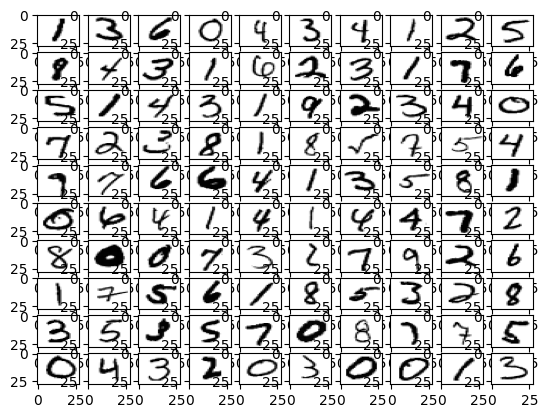

In [4]:
def plot_input_img(i) : 
    plt.imshow(x_train[i], cmap = 'binary')
    plt.title(y_train[i])
    plt.show()

fig, ax = plt.subplots(10, 10)
k = 0
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(x_train[k].reshape(28, 28), 
                        aspect='auto', cmap = 'binary')
        k += 1
plt.show()

In [5]:
# Converting Numpy to Tenor 
# Transforming the tenor based on availabe device

x_train = torch.from_numpy(x_train).to(device)
x_test = torch.from_numpy(x_test).to(device)
x_val = torch.from_numpy(x_val).to(device)

y_train = torch.from_numpy(y_train).to(device)
y_test = torch.from_numpy(y_test).to(device)
y_val = torch.from_numpy(y_val).to(device)

print("--------------------Updated Input Shape & Data Type --------------" ) 
print("X train shape : ", x_train.shape, "Data Type : " , type(x_train))
print("Y train shape : ", y_train.shape, "Data Type : ", type(y_train))
print("X test shape : ", x_test.shape, "Data Type : ", type(x_test))
print("Y test shape : ", y_test.shape, "Data Type : ", type(y_test))
print("X val shape : ", x_val.shape, "Data Type : ", type(x_val))
print("Y val shape : ", y_val.shape, "Data Type : ", type(y_val))

--------------------Updated Input Shape & Data Type --------------
X train shape :  torch.Size([54000, 1, 28, 28]) Data Type :  <class 'torch.Tensor'>
Y train shape :  torch.Size([54000, 10]) Data Type :  <class 'torch.Tensor'>
X test shape :  torch.Size([10000, 1, 28, 28]) Data Type :  <class 'torch.Tensor'>
Y test shape :  torch.Size([10000, 10]) Data Type :  <class 'torch.Tensor'>
X val shape :  torch.Size([6000, 1, 28, 28]) Data Type :  <class 'torch.Tensor'>
Y val shape :  torch.Size([6000, 10]) Data Type :  <class 'torch.Tensor'>


# LeNet 5 Implementation

1. First Layer 
* input: (28, 28, 1)
* convolution (kernel = 5 * 5), Feature Map = 6, Stride = 1, Activation = 'tanh'
* average pooling ( 2 * 2) : **Output** $\Rightarrow$ (14, 14 ,6)

1. Second Layer 
* input : (14, 14, 6)
* convolution (kernel = 5 * 5), Feature Map = 16,  Stride = 1, Activation = 'tanh'
* average pooling (2 * 2) : **Output** $\Rightarrow$ (5, 5, 16)

1. Third Layer 
* input : (5, 5, 16)
* convolution (kernel = 5 * 5), Feature Map = 120 ,  Stride = 1, Activation = 'tanh'
* **Output** $\Rightarrow$ (120, 1)

1. Fourth Layer 
* input : (120, 1)
* Fully Connected : (84, 1) 
* Fully Connected : (10, 1) $\Rightarrow$ **Output:**  (10, 1)


In [6]:
class LeNet(nn.Module) : 

    def __init__(self) : 
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding = 2, stride = 1)
        self.avg1 = nn.AvgPool2d(2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1)
        self.avg2 = nn.AvgPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels= 120, kernel_size=5, stride= 1)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(in_features=120 , out_features=84)
        self.fc2 = nn.Linear(in_features= 84, out_features= 10)

    def forward(self, input) : 

        x = input.view(-1, 1, 28, 28)
        x = F.tanh(self.conv1(x))
        x = self.avg1(x)
        x = F.tanh(self.conv2(x))
        x = self.avg2(x)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, x.shape[1])
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x 

    
def init_weight_normal(m):
        '''Takes in a module and initializes all linear layers with weight
           values taken from a normal distribution.'''

        classname = m.__class__.__name__
        # for every Linear layer in a model
        if type(m) == nn.Linear :
            y = m.in_features
            # m.weight.data shoud be taken from a normal distribution
            m.weight.data.normal_(0.0,1/np.sqrt(y))
            # m.bias.data should be 0
            m.bias.data.fill_(0)

Check Network Structure

In [7]:
model = LeNet()
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avg1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avg2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

Model Summary

In [8]:
summary(model=LeNet(), input_size=(1, 1, 28, 28),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
LeNet (LeNet)                            [1, 1, 28, 28]            [1, 10]                   --                        True
├─Conv2d (conv1)                         [1, 1, 28, 28]            [1, 6, 28, 28]            156                       True
├─AvgPool2d (avg1)                       [1, 6, 28, 28]            [1, 6, 14, 14]            --                        --
├─Conv2d (conv2)                         [1, 6, 14, 14]            [1, 16, 10, 10]           2,416                     True
├─AvgPool2d (avg2)                       [1, 16, 10, 10]           [1, 16, 5, 5]             --                        --
├─Conv2d (conv3)                         [1, 16, 5, 5]             [1, 120, 1, 1]            48,120                    True
├─Linear (fc1)                           [1, 120]                  [1, 84]                   10,164                    True
├─Linea

Backpropogation Network

In [9]:
def backpropgation(train_dataset, validation_dataset, model, loss, optimizer, accuracy, epochs = 10) : 


    model = model.to(device)
    print("Epoch \t Accuracy \t Loss")
    total_accuracy = []
    total_loss = []
    validation_accuracy = []
    validation_loss = []

    for epoch in range(epochs) : 
        train_acc = 0 
        train_loss = 0 

        # Training Loop 
        for x, y in train_dataset : 
            # Forward Pass
            y_hat = model(x)
            curr_loss = loss(y_hat, y)
            # Meteric
            train_loss += curr_loss.item()
            acc = accuracy(y_hat, y)
            train_acc += acc
            # Backward Pass 
            optimizer.zero_grad()
            curr_loss.backward()
            optimizer.step()


        total_accuracy.append((train_acc.item() / len(train_dataset))*100)
        total_loss.append(train_loss / len(train_dataset))


        # Validation Loop 
        val_loss, val_acc = 0, 0 
        model.eval()
        with torch.inference_mode() : 
            for x, y in validation_dataset : 
                # Forward Pass
                y_hat = model(x)
                curr_loss = loss(y_hat, y)
                val_loss += curr_loss.item()

                acc = accuracy(y_hat, y)
                val_acc += acc

        
        val_loss = val_loss / len(validation_dataset)
        val_acc  = val_acc.item() / len(validation_dataset)
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc * 100)


        print("Epoch : ", epoch + 1, "Traning Accuracy : ", total_accuracy[-1], "Training Loss : ", total_loss[-1], "Validation Accuracy : ", val_acc * 100, " Validation Loss : ", val_loss)
        

    return total_accuracy, total_loss, validation_accuracy, validation_loss

Packing Dataset (Train, Test, Validation)

In [10]:
batch_size = 32
train_dataset = data_utils.TensorDataset(x_train, y_train)
train_dataset_loader = data_utils.DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_dataset = data_utils.TensorDataset(x_test, y_test)
test_dataset_loader = data_utils.DataLoader(test_dataset, batch_size= batch_size, shuffle= True)

valid_dataset = data_utils.TensorDataset(x_val, y_val)
valid_dataset_loader = data_utils.DataLoader(valid_dataset, batch_size= batch_size, shuffle= True)


In [11]:

model = LeNet()
# Initialziing Weights for Model 
model.apply(init_weight_normal)
# Defining Loss - Multiclass Label

loss = nn.CrossEntropyLoss()
# Optimizer 
optimizer = optimizers.Adam(model.parameters(), lr = 0.001 * 5)
accuracy = Accuracy(task='multiclass', num_classes=10)
accuracy = accuracy.to(device)

# Computing Accuracy and Loss
train_accuracy_list, train_loss_list, validation_accuracy_list, validation_loss_list   = backpropgation(train_dataset= train_dataset_loader, validation_dataset= valid_dataset_loader, 
                                model = model, loss = loss, optimizer= optimizer, accuracy = accuracy, epochs = 25)

Epoch 	 Accuracy 	 Loss
Epoch :  1 Traning Accuracy :  4.520141456929428 Training Loss :  1.5283462191221273 Validation Accuracy :  7.57313738477991  Validation Loss :  1.5005644857883453
Epoch :  2 Traning Accuracy :  9.11267628601942 Training Loss :  1.499573198893059 Validation Accuracy :  10.867684952756191  Validation Loss :  1.5015508221819045
Epoch :  3 Traning Accuracy :  13.164807721901845 Training Loss :  1.4966501038503872 Validation Accuracy :  18.49401960981653  Validation Loss :  1.496199758128917
Epoch :  4 Traning Accuracy :  20.181048424887997 Training Loss :  1.493509495851553 Validation Accuracy :  21.948130587314036  Validation Loss :  1.50394680461985
Epoch :  5 Traning Accuracy :  34.83914922198978 Training Loss :  1.4941562316005264 Validation Accuracy :  45.26761237611162  Validation Loss :  1.499074211780061
Epoch :  6 Traning Accuracy :  47.378771451977194 Training Loss :  1.4928847629029605 Validation Accuracy :  49.84707527972282  Validation Loss :  1.498815

In [12]:
print("Traing Accuracy : ", train_accuracy_list)
print("Validation Accuracy : ", validation_accuracy_list)
print("------------------------------")
print("Train Loss : ", train_loss_list)
print("Validation Loss : ", validation_loss_list)

Traing Accuracy :  [4.520141456929428, 9.11267628601942, 13.164807721901845, 20.181048424887997, 34.83914922198978, 47.378771451977194, 56.915210886589165, 63.085908573385666, 70.2343402880628, 76.09653563296061, 80.36880131581383, 81.46772339445721, 87.48739522780288, 90.04301098285693, 89.7076936694683, 90.88373410193276, 94.38680495131072, 92.88710463103524, 94.9871479052503, 95.57283952902843, 96.10983319757109, 95.87175992992817, 96.61116758229043, 96.56764749102118, 96.1550527274326]
Validation Accuracy :  [7.57313738477991, 10.867684952756191, 18.49401960981653, 21.948130587314036, 45.26761237611162, 49.84707527972282, 60.20112544932263, 67.38031265583444, 72.91722399123172, 75.62332153320312, 81.20348504249085, 82.6196792277884, 86.12699305757563, 91.614021138942, 90.975724889877, 92.60802573346078, 94.14726419651763, 93.54221262830369, 95.0315921864611, 97.06282920025765, 95.51529579974235, 95.89426568213929, 96.91990791483128, 96.95477587111453, 95.45380612637135]
-----------

Computing Test Accuracy 

In [13]:
# Test  
test_loss, test_acc = 0, 0 
model.eval()
with torch.inference_mode() : 
    for x, y in test_dataset_loader : 
        # Forward Pass
        y_hat = model(x)
        curr_loss = loss(y_hat, y)
        test_loss += curr_loss.item()

        acc = accuracy(y_hat, y)
        test_acc += acc

        
    test_loss = test_loss / len(test_dataset_loader)
    test_acc  = test_acc.item() / len(test_dataset_loader)

print("Test Accuracy % : ", test_acc * 100)
print("Test Loss : ", test_loss)
    

Test Accuracy % :  95.61299576926918
Test Loss :  1.5011095197056048


Plotting Train vs Validation Accuracy and Loss

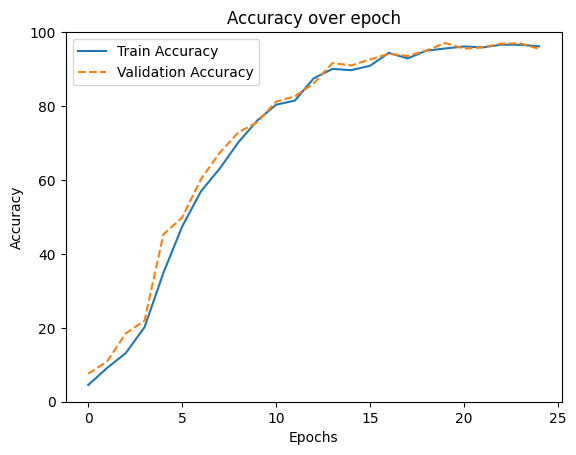

In [14]:
# Plot Accuracy and Loss Model 
def plot_accuracy(train_accuracy_list, validation_accuracy_list) : 
    plt.plot(train_accuracy_list, label='Train Accuracy')
    plt.plot(validation_accuracy_list, label='Validation Accuracy', linestyle = 'dashed')
    plt.ylim([0, 100])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epoch')
    plt.legend()
    plt.show()

plot_accuracy(train_accuracy_list= train_accuracy_list, validation_accuracy_list= validation_accuracy_list)


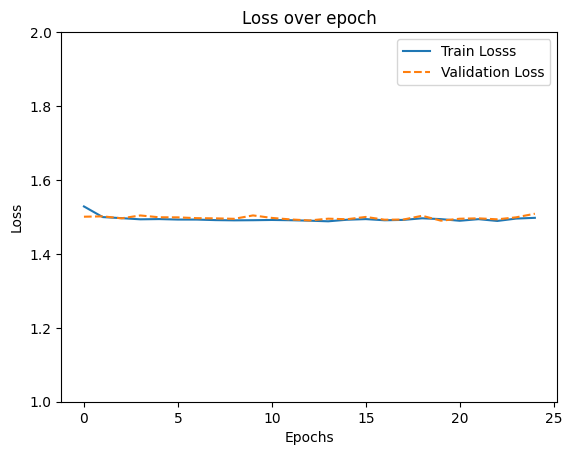

In [15]:
# Plot Accuracy and Loss Model 
def plot_loss(train_accuracy_loss, validation_accuracy_loss) : 
    plt.plot(train_accuracy_loss, label='Train Losss')
    plt.plot(validation_accuracy_loss, label='Validation Loss', linestyle = 'dashed')
    plt.ylim([1, 2])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epoch')
    plt.legend()
    plt.show()

plot_loss(train_accuracy_loss= train_loss_list, validation_accuracy_loss= validation_loss_list)
